**Comparing top performing model against triage tests and TPP**
---

In [10]:
import joblib

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

Loading in model from previous notebook

In [11]:
# Load model
lasso_on_rfe_no_demo = joblib.load("lasso_on_rfe_no_demo.pkl")

# Load test data
x_test_no_demo = joblib.load("x_test_no_demo.pkl")
y_test_no_demo = joblib.load("y_test_no_demo.pkl")

# Load feature list
overlap_features = joblib.load("overlap_features.pkl")

**Getting Sens and Spec of Model**

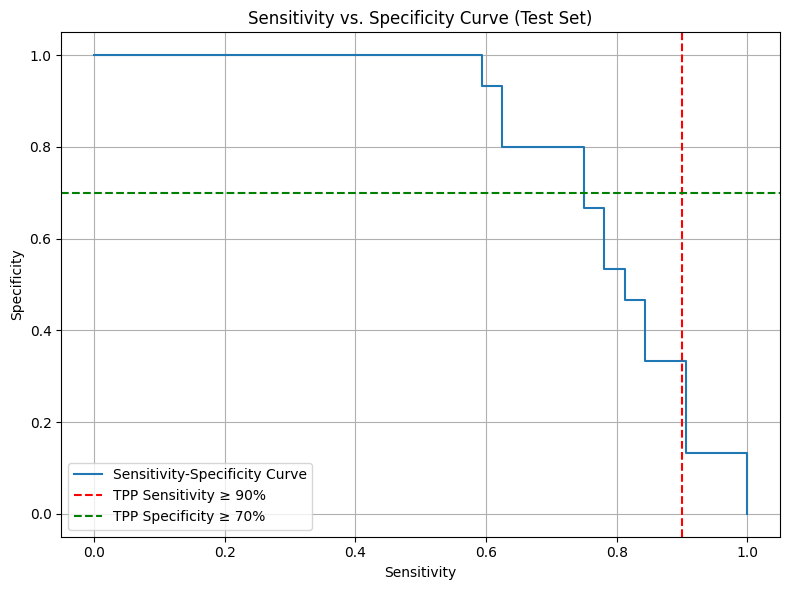

Closest to TPP target: 
  Sensitivity = 0.781
  Specificity = 0.667
  Threshold   = 0.525
First point with Sensitivity ≥ 90%:
  Sensitivity = 0.906
  Specificity = 0.333
  Threshold   = 0.377


In [12]:
# predicted probabilities from model
probs = lasso_on_rfe_no_demo.predict_proba(x_test_no_demo[overlap_features])[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_no_demo, probs)
specificity = 1 - fpr

# Sens. v Spec.
plt.figure(figsize=(8, 6))
plt.plot(tpr, specificity, label="Sensitivity-Specificity Curve")
plt.axvline(0.90, color="r", linestyle="--", label="TPP Sensitivity ≥ 90%")
plt.axhline(0.70, color="g", linestyle="--", label="TPP Specificity ≥ 70%")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("Sensitivity vs. Specificity Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output10_ModelSensVsSpec.pdf", bbox_inches="tight")
xlim = plt.xlim()
ylim = plt.ylim()
plt.show()

target_sens = 0.90
target_spec = 0.70


# TPP Optimized

# Find closest point
distances = np.sqrt((tpr - target_sens)**2 + ((1 - fpr) - target_spec)**2)
closest_idx = np.argmin(distances)
chosen_sens = tpr[closest_idx]
chosen_spec = 1 - fpr[closest_idx]
chosen_thresh = thresholds[closest_idx]

print("Closest to TPP target: ")
print(f"  Sensitivity = {chosen_sens:.3f}")
print(f"  Specificity = {chosen_spec:.3f}")
print(f"  Threshold   = {chosen_thresh:.3f}")


# Sensitivity optimized
# first point where sensitivity >= 90%
target_sens = 0.90
idx_sens90 = np.where(tpr >= target_sens)[0][0]

sens_90plus = tpr[idx_sens90]
spec_90plus = 1 - fpr[idx_sens90]  # bc this is the 1-FPR = spec
thresh_90plus = thresholds[idx_sens90]

print("First point with Sensitivity ≥ 90%:")
print(f"  Sensitivity = {sens_90plus:.3f}")
print(f"  Specificity = {spec_90plus:.3f}")
print(f"  Threshold   = {thresh_90plus:.3f}")

**Comparing with common triage tests:**

In [13]:
# test = {sensitivity : specificity}
models = [
    #  {"Name": "WHO TPP Minimum", "Sensitivity": .90, "Specificity": .70},
    {"Name": "CRP", "Sensitivity": .84, "Specificity": .61},
    {"Name": "CXR", "Sensitivity": .76, "Specificity": .82},
    {"Name": "CXR + CAD", "Sensitivity": .90, "Specificity": .74},
    {"Name": "Urine LAM", "Sensitivity": .42, "Specificity": .99},
    {"Name": "VOC Model (TPP Optimized)", "Sensitivity": .781, "Specificity": .667},
    {"Name": "VOC Model (Sensitivity Optimized)", "Sensitivity": .906, "Specificity": .333}
]

<Figure size 1000x600 with 0 Axes>

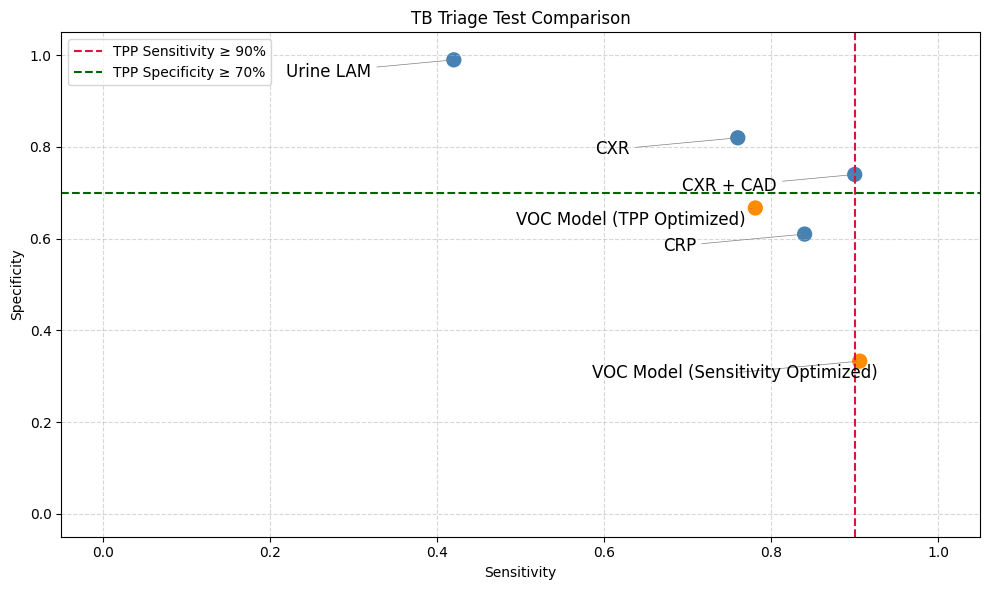

In [14]:
# Extract for plotting
names = [m["Name"] for m in models]
sensitivities = [m["Sensitivity"] for m in models]
specificities = [m["Specificity"] for m in models]


plt.figure(figsize=(10, 6))

colors = ["darkorange" if "VOC" in name else "steelblue" for name in names]


plt.figure(figsize=(10, 6))
plt.scatter(sensitivities, specificities, s=100, color=colors)

center_x, center_y = 0.5, 0.5

for i, name in enumerate(names):
    plt.annotate(
        name,
        xy=(sensitivities[i], specificities[i]),
        xytext=(-90, -12),
        textcoords="offset points",
        ha="center",
        fontsize=12,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)
    )

plt.axvline(.90, color="crimson", linestyle="--", label="TPP Sensitivity ≥ 90%")
plt.axhline(.70, color="darkgreen", linestyle="--", label="TPP Specificity ≥ 70%")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("TB Triage Test Comparison")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# axis limits from previous plot to make it match up nicely
plt.xlim(xlim)
plt.ylim(ylim)

plt.tight_layout()
# plt.savefig("output_TriageSensVsSpec_MatchingLimits.pdf", bbox_inches="tight")
plt.show()

<Figure size 1000x600 with 0 Axes>

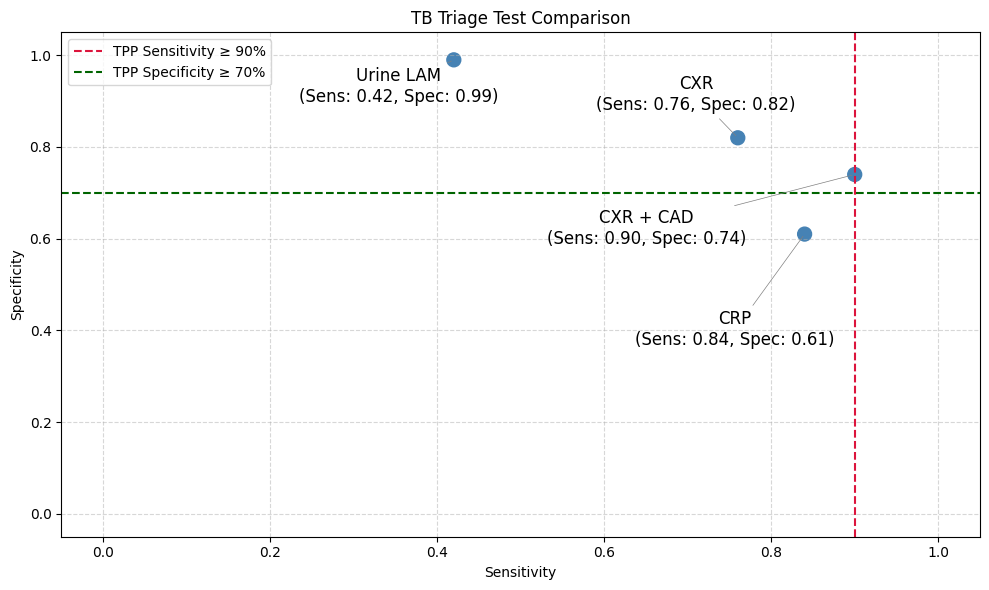

In [15]:
# for figure 1 of background
excluded_names = [
    "VOC Model (TPP Optimized)",
    "VOC Model (Sensitivity Optimized)"
]

filtered_models = [m for m in models if m["Name"] not in excluded_names]

names = [m["Name"] for m in filtered_models]
sensitivities = [m["Sensitivity"] for m in filtered_models]
specificities = [m["Specificity"] for m in filtered_models]


# did these custom for better presentation
label_offsets = {
    "CXR": (-30, 20),
    "CRP": (-50, -80),
    "Urine LAM": (-40, -30),
    "CXR + CAD": (-150, -50),
}
plt.figure(figsize=(10, 6))

colors = ["darkorange" if "VOC" in name else "steelblue" for name in names]


plt.figure(figsize=(10, 6))
plt.scatter(sensitivities, specificities, s=100, color=colors)

center_x, center_y = 0.5, 0.5

for i, name in enumerate(names):
    dx, dy = label_offsets.get(name, (-90, -12))  # fallback offset
    plt.annotate(
        f"{name}\n(Sens: {sensitivities[i]:.2f}, Spec: {specificities[i]:.2f})",
        xy=(sensitivities[i], specificities[i]),
        xytext=(dx, dy),
        textcoords="offset points",
        ha="center",
        fontsize=12,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)
    )

plt.axvline(.90, color="crimson", linestyle="--", label="TPP Sensitivity ≥ 90%")
plt.axhline(.70, color="darkgreen", linestyle="--", label="TPP Specificity ≥ 70%")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("TB Triage Test Comparison")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# axis limits from previous plot to make it match up nicely
plt.xlim(xlim)
plt.ylim(ylim)

plt.tight_layout()
plt.savefig("output0_figure1.pdf", bbox_inches="tight")
plt.show()

In [18]:
# Combining models
def get_model_metrics(name):
    name = str(name)
    for model in models:
        if model["Name"] == name:
            return model["Sensitivity"], model["Specificity"]
    return None, None


def combine_models(model1, model2):
    results = []
    print("---"*10)
    print(f"Comparing {model1} with {model2}: \n")
    sens_model1, spec_model1 = get_model_metrics(model1)
    sens_model2, spec_model2 = get_model_metrics(model2)
    print(f"{model1} has a Sensitivity of: {sens_model1} and a Specificity of: {spec_model1}")
    print(f"{model2} has a Sensitivity of: {sens_model2} and a Specificity of: {spec_model2}")
    print("\n")
    # parallel (prioritizes sensitivity for max detection)
    sens_parallel = 1 - (1 - sens_model1) * (1 - sens_model2)
    spec_parallel = spec_model1 * spec_model2
    print(f"Parallel Combined Sensitivity: {sens_parallel:.3f} Combined Specificity: {spec_parallel:.3f}")

    results.append({
            "Test combined with": model2,
            "VOC Variant": model1.replace("VOC Model (", "").replace(")", ""),
            "Combo Type": "Parallel",
            "Sensitivity (%)": round(sens_parallel * 100, 1),
            "Specificity (%)": round(spec_parallel * 100, 1)
        })

    # serial (min false positives)
    sens_serial = sens_model1 * sens_model2
    spec_serial = 1 - (1 - spec_model1) * (1 - spec_model2)
    print(f"Serial Combined Sensitivity: {sens_serial:.3f} Combined Specificity: {spec_serial:.3f}")

    results.append({
            "Test combined with": model2,
            "VOC Variant": model1.replace("VOC Model (", "").replace(")", ""),
            "Combo Type": "Serial",
            "Sensitivity (%)": round(sens_serial * 100, 1),
            "Specificity (%)": round(spec_serial * 100, 1)
        })
    return pd.DataFrame(results)


######################################
models_to_test = [
    "VOC Model (Sensitivity Optimized)",
    "VOC Model (TPP Optimized)"
]
all_results = []
print("CXR")

for voc_model_type in models_to_test:
    df = combine_models(voc_model_type, "CXR")
    all_results.append(df)

######################################
print("\n")
print("Urine LAM")

for voc_model_type in models_to_test:
    df = combine_models(voc_model_type, "Urine LAM")
    all_results.append(df)

######################################
summary_combined_models = pd.concat(all_results, ignore_index=True)
summary_combined_models.to_excel("output11_CombinedModelsParallelandSerial.xlsx", index=False)
summary_combined_models

CXR
------------------------------
Comparing VOC Model (Sensitivity Optimized) with CXR: 

VOC Model (Sensitivity Optimized) has a Sensitivity of: 0.906 and a Specificity of: 0.333
CXR has a Sensitivity of: 0.76 and a Specificity of: 0.82


Parallel Combined Sensitivity: 0.977 Combined Specificity: 0.273
Serial Combined Sensitivity: 0.689 Combined Specificity: 0.880
------------------------------
Comparing VOC Model (TPP Optimized) with CXR: 

VOC Model (TPP Optimized) has a Sensitivity of: 0.781 and a Specificity of: 0.667
CXR has a Sensitivity of: 0.76 and a Specificity of: 0.82


Parallel Combined Sensitivity: 0.947 Combined Specificity: 0.547
Serial Combined Sensitivity: 0.594 Combined Specificity: 0.940


Urine LAM
------------------------------
Comparing VOC Model (Sensitivity Optimized) with Urine LAM: 

VOC Model (Sensitivity Optimized) has a Sensitivity of: 0.906 and a Specificity of: 0.333
Urine LAM has a Sensitivity of: 0.42 and a Specificity of: 0.99


Parallel Combined Sen

,Test combined with,VOC Variant,Combo Type,Sensitivity (%),Specificity (%)
0,CXR,Sensitivity Optimized,Parallel,97.7,27.3
1,CXR,Sensitivity Optimized,Serial,68.9,88.0
2,CXR,TPP Optimized,Parallel,94.7,54.7
3,CXR,TPP Optimized,Serial,59.4,94.0
4,Urine LAM,Sensitivity Optimized,Parallel,94.5,33.0
5,Urine LAM,Sensitivity Optimized,Serial,38.1,99.3
6,Urine LAM,TPP Optimized,Parallel,87.3,66.0
7,Urine LAM,TPP Optimized,Serial,32.8,99.7


In [19]:
# redoing this to include the TPP now
models_data = [
    {"Model": "CRP", "Sensitivity": 0.84, "Specificity": 0.61},
    {"Model": "CXR", "Sensitivity": 0.76, "Specificity": 0.82},
    {"Model": "CXR + CAD", "Sensitivity": 0.90, "Specificity": 0.74},
    {"Model": "Urine LAM", "Sensitivity": 0.42, "Specificity": 0.99},
    {"Model": "VOC Model (TPP Optimized)", "Sensitivity": .781, "Specificity": .667},
    {"Model": "VOC Model (Sensitivity Optimized)", "Sensitivity": .906, "Specificity": .333},
    {"Model": "WHO TPP", "Sensitivity": 0.90, "Specificity": 0.70},
    {"Model": "TPP Optimized with CXR (Parallel)", "Sensitivity": .947, "Specificity": .547},
    {"Model": "TPP Optimized with Urine LAM (Parallel)", "Sensitivity": .873, "Specificity": 0.660}
]

df = pd.DataFrame(models_data)
# to percent
df["Sensitivity"] = (df["Sensitivity"] * 100).round(1)
df["Specificity"] = (df["Specificity"] * 100).round(1)

# Reorder
df = df[["Model", "Sensitivity", "Specificity"]]
custom_order = [
    "WHO TPP",
    "VOC Model (TPP Optimized)",
    "VOC Model (Sensitivity Optimized)",
    "TPP Optimized with CXR (Parallel)",
    "TPP Optimized with Urine LAM (Parallel)",
    "CXR + CAD",
    "CXR",
    "CRP",
    "Urine LAM"
]
df["Model"] = pd.Categorical(df["Model"], categories=custom_order, ordered=True)
df = df.sort_values("Model").reset_index(drop=True)
print(df)
df.to_excel("output_tb_triage_comparison_table.xlsx", index=False)


summary_combined_models.to_excel("output12_summary_combined_models_interpretation.xlsx", index=False)

                                     Model  Sensitivity  Specificity
0                                  WHO TPP         90.0         70.0
1                VOC Model (TPP Optimized)         78.1         66.7
2        VOC Model (Sensitivity Optimized)         90.6         33.3
3        TPP Optimized with CXR (Parallel)         94.7         54.7
4  TPP Optimized with Urine LAM (Parallel)         87.3         66.0
5                                CXR + CAD         90.0         74.0
6                                      CXR         76.0         82.0
7                                      CRP         84.0         61.0
8                                Urine LAM         42.0         99.0


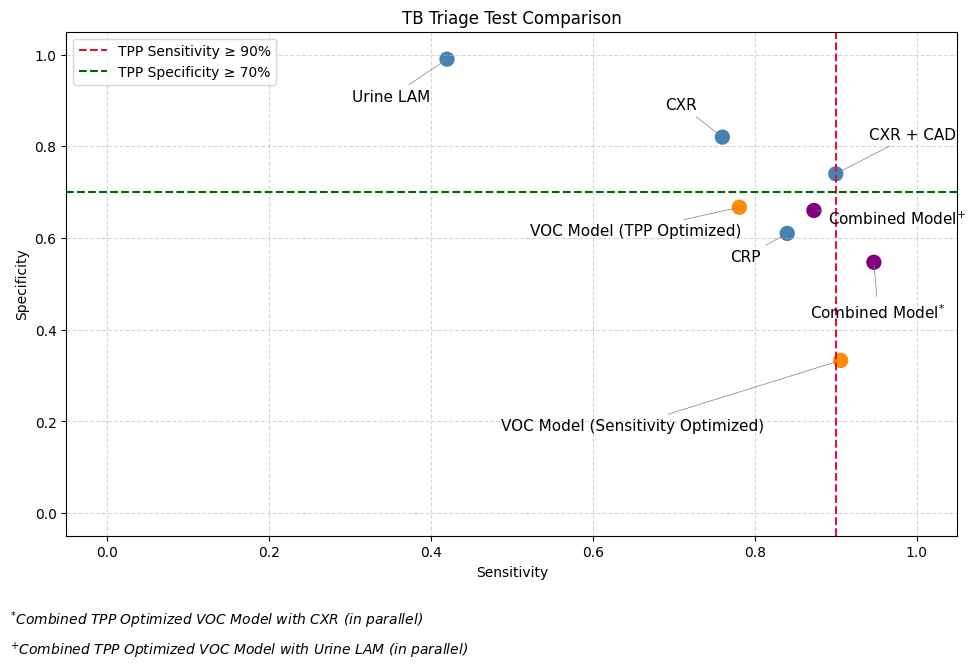

In [20]:
# replotting but with comparisons, too
filtered_models = [m for m in models_data if m["Model"] != "WHO TPP"]
names = [m["Model"] for m in filtered_models]
sensitivities = [m["Sensitivity"] for m in filtered_models]
specificities = [m["Specificity"] for m in filtered_models]


colors = []  # getting fancy with colors
for name in names:
    if "Parallel" in name:
        colors.append("purple")
    elif "VOC" in name:
        colors.append("darkorange")
    else:
        colors.append("steelblue")

# did these custom for better presentation
label_offsets = {
    "VOC Model (Sensitivity Optimized)": (-150, -50),
    "VOC Model (TPP Optimized)": (-75, -20),
    "CXR": (-30, 20),
    "CRP": (-30, -20),
    "Urine LAM": (-40, -30),
    "CXR + CAD": (55, 25),
    "TPP Optimized with CXR (Parallel)": (3, -40),
    "TPP Optimized with Urine LAM (Parallel)": (60, -10)
}

plt.figure(figsize=(10, 6))
plt.scatter(sensitivities, specificities, s=100, color=colors)

center_x, center_y = 0.5, 0.5

for i, name in enumerate(names):
    display_name = name
    if name == "TPP Optimized with CXR (Parallel)":
        display_name = r"$\mathrm{Combined\ Model}^{*}$"
    if name == "TPP Optimized with Urine LAM (Parallel)":
        display_name = r"$\mathrm{Combined\ Model}^{+}$"
    dx, dy = label_offsets.get(name, (-10, -10))  # fallback offset
    plt.annotate(
        display_name,
        xy=(sensitivities[i], specificities[i]),
        xytext=(dx, dy),
        textcoords="offset points",
        ha="center",
        fontsize=11,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)
    )

plt.axvline(.90, color="crimson", linestyle="--", label="TPP Sensitivity ≥ 90%")
plt.axhline(.70, color="darkgreen", linestyle="--", label="TPP Specificity ≥ 70%")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("TB Triage Test Comparison")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.figtext(
    0.01, -0.05,  # x and y in figure coords; lower y = lower on the page
    r"$^{*}$Combined TPP Optimized VOC Model with CXR (in parallel)",
    ha="left",
    fontsize=10,
    style="italic"
)
plt.figtext(
    0.01, -0.10,  # x and y in figure coords; lower y = lower on the page
    r"$^{+}$Combined TPP Optimized VOC Model with Urine LAM (in parallel)",
    ha="left",
    fontsize=10,
    style="italic"
)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()
plt.savefig("output13_overall_TB_Triage_test_comparison.pdf", bbox_inches="tight")
plt.show()